BAIT 508 Group Project: Industry Analysis

PROJECT OVERVIEW: 
The goal of this project is to conduct an in-depth analysis of public US firms within selected industry sector(s) using various data analyses and natural language processing (NLP) techniques that we learned in BAIT 508. Each team will choose at least one industry sector to investigate and utilize multiple datasets to extract valuable industry insights from the data.

The project will utilize three datasets (located in the data folder):
•	public_firms.csv
•	major_groups.csv
•	2020_10K_item1_full.csv

In [4]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.style as style
import string
from DocumentSimilarity import DocumentSimilarity
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
filepath_data= r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data'
public_firms=pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\public_firms.csv')
twenty20_10K_item1_full=pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\2020_10K_item1_full.csv')
major_groups =pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\major_groups.csv')

Part 1. Quantitative Analysis of the Industry Sector

A.	[Industry Sector Selection and Data Filtering; 20 points] 

1.	The file "data/major_groups.csv" contains a list of major industry sectors and their corresponding codes (column "major_group"). Your first task is to choose at least one industry sector that interests your group. It is okay if multiple groups choose the same industry sector, so you don’t need to coordinate with other groups.


In [6]:
agri = ( '1','2','7','8','9') #Agriculture and Related Industries
wholesale = ( '50','51') #Wholesale
food =('54') #Food
busi_serv = ('73') #BusinessSerivices
wholesale_only = ('50')

2.	Next, filter the data in "data/public_firms.csv" to only include the firms belonging to the industry sector(s) you have selected. You can use the "major_group" value, which corresponds to the first two digits of each firm’s SIC code,  to identify relevant firms. For example, if you are interested in the “Business Service” sector and its "major_group" code is 73, you should retain all firms whose SIC codes start with 73. 

In [7]:
industries_agri = public_firms[public_firms['sic'].astype(str).str.startswith(agri)]
industries_wholesale = public_firms[public_firms['sic'].astype(str).str.startswith(wholesale)]
industries_food = public_firms[public_firms['sic'].astype(str).str.startswith(food)]
industries_busi_serv = public_firms[public_firms['sic'].astype(str).str.startswith(busi_serv)]
industries_wholesale_only =public_firms[public_firms['sic'].astype(str).str.startswith(wholesale_only)]
fname_industries = industries_wholesale_only

3.	Now, answer the following questions based on the filtered dataset: 

a.	How many unique firm-year ("fyear") observations are there in the filtered dataset?


In [8]:
unique_fyear=len(fname_industries['fyear'].unique())
unique_fyear

27

b.	How many unique firms are there in the filtered dataset?



In [9]:
unique_firms = len(fname_industries['conm'].unique())
unique_firms

363

c.	How many firms in the filtered dataset have records over all 27 years (1994-2020)?

In [10]:
filtered_firms = fname_industries.groupby('conm').filter(lambda x: len(x) == unique_fyear)
num_firms = len(filtered_firms['conm'].unique())
num_firms

7

B.	[Preliminary Analysis; 20 points] Answer the following questions:

1.	What are the top 10 firms with the highest stock price (column "prcc_c") in the year 2020?


In [11]:
top_ten_stocks = fname_industries.sort_values('prcc_c', ascending=False).loc[fname_industries['fyear'] == 2020].head(10)
top_ten_stocks[['conm']]

,conm
17053,GRAINGER (W W) INC
120862,POOL CORP
26157,MITSUI & CO LTD
42140,WATSCO INC
90303,SITEONE LANDSCAPE SUPPLY INC
95925,CDW CORP
104051,COPART INC
107901,RELIANCE STEEL & ALUMINUM CO
16458,GENUINE PARTS CO
3081,ARROW ELECTRONICS INC


2.	What are the top 10 firms with the highest sales (column "sale") in the entire history of the dataset?

In [12]:
top_10_firm = fname_industries.groupby('conm').sum(numeric_only=True).sort_values('sale', ascending=False).head(10)
top_10_firm[['sale']]


,sale
conm,
MITSUI & CO LTD,2076384.551
INGRAM MICRO INC,613663.628
TECH DATA CORP,542110.884
FERGUSON PLC,440136.786
ARROW ELECTRONICS INC,425701.864
AVNET INC,404682.928
GENUINE PARTS CO,293829.516
SYNNEX CORP,217835.129
CDW CORP,204187.757


3.	What is the geographical distribution (column "location") of all the firms? In other words, how many firms are there in each location? Please list the top 10 locations. 

In [13]:
unique_locations = fname_industries.groupby('location')['conm'].nunique().sort_values(ascending=False)
unique_locations

location
USA    332
CHN     11
HKG      6
GBR      5
CAN      2
ISR      2
AUS      1
BEL      1
BMU      1
JPN      1
VGB      1
Name: conm, dtype: int64

4.	Create a line chart to show the average stock price (column "prcc_c") in the selected sector(s) across the years. If you have selected multiple sectors, draw multiple lines to show them separately.


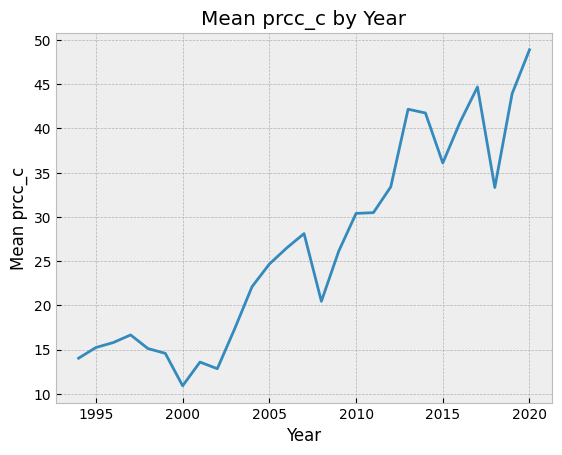

In [14]:
#mean_prcc_c = fname_industries.groupby(['sic', 'fyear'])['prcc_c'].mean()

#for i, industry in enumerate(fname_industries['sic'].unique()):
  #  industry_data = mean_prcc_c.loc[industry]
  #  axes[i].plot(industry_data.index, industry_data.values)
  #  axes[i].set_xlabel('')
  #  axes[i].set_xticks([])
  #  axes[i].set_ylabel('')
  #  axes[i].set_title(f'Industry_{industry}')

mean_prcc_c = fname_industries.groupby(['fyear'])['prcc_c'].mean()
style.use('bmh')

plt.plot(mean_prcc_c.index, mean_prcc_c.values)
plt.xlabel('Year')
plt.ylabel('Mean prcc_c')
plt.title('Mean prcc_c by Year')
plt.show()

5.	Which firm was affected the most by the 2008 Financial Crisis, as measured by the percentage drop in stock price from 2007 to 2008?

In [15]:

prcc_c_2008 = fname_industries[fname_industries['fyear'] == 2008]
prcc_c_2007 = fname_industries[fname_industries['fyear'] == 2007]
prcc_merged = prcc_c_2008.merge(prcc_c_2007,
                 how='outer', suffixes=('_x', '_y'), on = 'gvkey')
prcc_merged.rename(columns={'prcc_c_x': 'prccc2008', 'prcc_c_y': 'prccc2007','location_x':'location','conm_x':'conm'}, inplace=True)
prcc_merged.drop(prcc_merged.filter(regex=('_'),).columns, axis=1, inplace=True)
prcc_merged.dropna(inplace=True)
prcc_merged.rename(columns={'prccc2008': 'prcc_c_2008', 'prccc2007': 'prcc_c_2007'}, inplace=True)
prcc_merged['prcc_c_drop'] = (prcc_merged['prcc_c_2008'] - prcc_merged['prcc_c_2007'])*100/prcc_merged['prcc_c_2007']
prcc_merged.sort_values('prcc_c_drop', inplace=True)
prcc_merged.reset_index(drop=True,inplace=True)
most_affected_firm = prcc_merged.iloc[[0]]
most_affected_firm

,gvkey,location,conm,prcc_c_2008,prcc_c_2007,prcc_c_drop
0,121840,USA,GEORGE FOREMAN ENTERPRISES,0.045,3.5,-98.714286


In [16]:
fname_industries.columns

Index(['gvkey', 'fyear', 'location', 'conm', 'ipodate', 'sic', 'prcc_c', 'ch',
       'ni', 'asset', 'sale', 'roa'],
      dtype='object')

6.	Plot the average Return on Assets (ROA) for the firms located in the “USA” across the years. ROA is calculated as ni/asset.

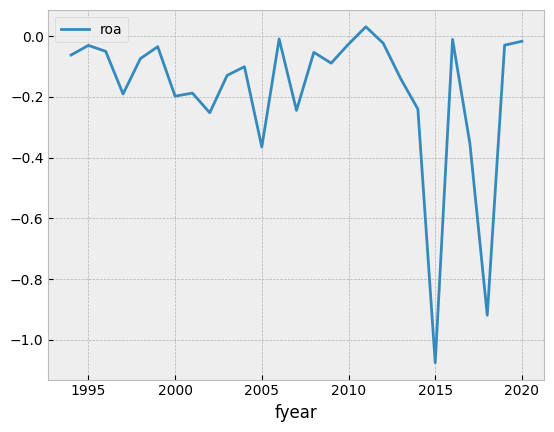

In [17]:
fname_industries_roa = fname_industries.copy()
fname_industries_roa['roa'] = fname_industries['ni'] / fname_industries['asset']
usa_roa_yearly_mean_plot = fname_industries_roa[fname_industries_roa['location'] == 'USA'].groupby('fyear')['roa'].mean().plot(legend=True)

Part 2. Text Analysis on the Industry Sector

C.	[Text Cleaning; 10 points] The file "data/2020_10K_item1_full.csv" contains a sample of 5,988 firms and their “item 1” content in their 10-K reports in the year 2020.  Load the dataset as a DataFrame and create a new column containing the cleaned text for each “item1” content. Follow the steps below to clean the text:

1.	Convert all words to lowercase.


In [18]:
twenty20_10K_item1_clean = twenty20_10K_item1_full.copy()
#twenty20_10K_item1_clean.drop_duplicates(inplace=True)
twenty20_10K_item1_clean['item_1_text'] = twenty20_10K_item1_full['item_1_text'].str.lower()
twenty20_10K_item1_clean

,cik,year,name,item_1_text,gvkey
0,1041588,2020,ACCESS-POWER INC,fixed expenses are previosuly documented in an...,66119
1,315374,2020,HURCO COMPANIES INC,"general hurco companies, inc. is an internatio...",5788
2,1622996,2020,"ACRO BIOMEDICAL CO., LTD.",we have been engaged in the business of develo...,27584
3,1191334,2020,Chun Can Capital Group,corporate history chun can capital group (form...,153614
4,1191334,2020,Chun Can Capital Group,corporate history chun can capital group (form...,153614
...,...,...,...,...,...
5476,740664,2020,R F INDUSTRIES LTD,"general rf industries, ltd. (together with sub...",2829
5477,1074828,2020,"KNOW LABS, INC.","background and capital structure know labs, in...",166430
5478,40570,2020,GEE Group Inc.,"general gee group inc. (the company , us , ...",5050
5479,1341726,2020,"GULFSLOPE ENERGY, INC.","general gulfslope energy, inc. is an independe...",175595


2.	Remove punctuations.

3.	Remove stop words based on the list of English stop words in NLTK.

In [19]:
translator = str.maketrans('', '', string.punctuation)
sw = stopwords.words('english')
def clean_text(text):
    clean_text = text.lower()
    clean_text = clean_text.translate(translator)
    clean_words = [w for w in clean_text.split() if w not in sw]
    return ' '.join(clean_words)

In [20]:
try:
    twenty20_10K_item1_clean = pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\twenty20_10K_item1_clean.csv')
except:
    twenty20_10K_item1_clean['item_1_clean'] = twenty20_10K_item1_clean['item_1_text'].apply(clean_text).reset_index(drop=True)
    twenty20_10K_item1_clean.drop(['name'],axis = 1,inplace=True)
    twenty20_10K_item1_clean.to_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\twenty20_10K_item1_clean.csv',index=False)  

#twenty20_10K_item1_clean['item_1_clean'] = twenty20_10K_item1_clean['item_1_text'].apply(clean_text).reset_index(drop=True)
#twenty20_10K_item1_clean.drop(['name'],axis = 1,inplace=True)
#twenty20_10K_item1_clean.to_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\twenty20_10K_item1_clean.csv',index=False) 
twenty20_10K_item1_clean = pd.read_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\twenty20_10K_item1_clean.csv')    
twenty20_10K_item1_clean

,cik,year,item_1_text,gvkey,item_1_clean
0,1041588,2020,fixed expenses are previosuly documented in an...,66119,fixed expenses previosuly documented 8k 235000...
1,315374,2020,"general hurco companies, inc. is an internatio...",5788,general hurco companies inc international indu...
2,1622996,2020,we have been engaged in the business of develo...,27584,engaged business developing marketing products...
3,1191334,2020,corporate history chun can capital group (form...,153614,corporate history chun capital group formerly ...
4,1191334,2020,corporate history chun can capital group (form...,153614,corporate history chun capital group formerly ...
...,...,...,...,...,...
5476,740664,2020,"general rf industries, ltd. (together with sub...",2829,general rf industries ltd together subsidiarie...
5477,1074828,2020,"background and capital structure know labs, in...",166430,background capital structure know labs inc inc...
5478,40570,2020,"general gee group inc. (the company , us , ...",5050,general gee group inc company us incorporated ...
5479,1341726,2020,"general gulfslope energy, inc. is an independe...",175595,general gulfslope energy inc independent crude...


D.	[Keyword Analysis; 20 points] Conduct keywords analysis on your selected industry sector(s). Follow the steps below to complete the analysis:

1.	Create a new DataFrame that includes only firms in your selected industry sectors. Ensure that you merge the 10-K data with the previous "public_firm.csv" data using an inner join.


In [21]:
public_firms_2020 = fname_industries[fname_industries['fyear'] == 2020]

In [22]:
merged_pf_i1_2020 = public_firms_2020.merge(twenty20_10K_item1_clean, how='inner', on='gvkey')
merged_pf_i1_2020.head(2)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,cik,year,item_1_text,item_1_clean
0,1004,2020,USA,AAR CORP,1988/01/01,5080,36.22,51.800,35.800,1539.700,1651.400,0.023251,1750,2020,our business we are the largest producer and d...,business largest producer distributor shell eg...
1,1773,2020,USA,ARROW ELECTRONICS INC,NaN,5065,97.30,373.615,584.438,17053.911,28673.363,0.034270,7536,2020,"arrow electronics, inc. (the company or arr...",arrow electronics inc company arrow global pro...


2.	Generate the top 10 keywords for each firm based on two different methods: word counts and TF-IDF score.

In [23]:
def get_keywords_wc_top10(text):
    c = Counter(text.lower().split())
    words = []
    for pair in c.most_common(10):
        words.append(pair[0])
    return ' '.join([x[0] for x in c.most_common(10)])
def get_keywords_tfidf_top10(document_list):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(document_list)
    feature_names = vectorizer.get_feature_names_out()
    top_keywords = []
    for i in range(len(document_list)):
        feature_index = tfidf_matrix[i, :].nonzero()[1]
        tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
        sorted_tfidf_scores = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
        top_keywords.append(' '.join([feature_names[i] for i, _ in sorted_tfidf_scores[:10]]))
    return top_keywords


merged_pf_i1_2020['keyword_wc_top10'] = merged_pf_i1_2020.item_1_clean.apply(get_keywords_wc_top10)
merged_pf_i1_2020['keyword_tfidf_top10'] = get_keywords_tfidf_top10(merged_pf_i1_2020.item_1_clean.tolist())

merged_pf_i1_2020.to_csv(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\data\merged_pf_i1_2020.csv',index=False)
merged_pf_i1_2020.head(5)

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,cik,year,item_1_text,item_1_clean,keyword_wc_top10,keyword_tfidf_top10
0,1004,2020,USA,AAR CORP,1988/01/01,5080,36.22,51.800,35.800,1539.700,1651.400,0.023251,1750,2020,our business we are the largest producer and d...,business largest producer distributor shell eg...,eggs shell egg production us customers special...,eggs shell egg cagefree production conventiona...
1,1773,2020,USA,ARROW ELECTRONICS INC,NaN,5065,97.30,373.615,584.438,17053.911,28673.363,0.034270,7536,2020,"arrow electronics, inc. (the company or arr...",arrow electronics inc company arrow global pro...,company global business president chief vice c...,company ecs president vice global chief arrow ...
2,1919,2020,USA,AVNET INC,NaN,5065,35.11,477.038,-31.081,8105.197,17634.333,-0.003835,8858,2020,"background caci international inc (caci), a de...",background caci international inc caci delawar...,business caci government operations technology...,caci mission business government intelligence ...
3,2101,2020,USA,APPLIED INDUSTRIAL TECH INC,NaN,5080,77.99,268.551,24.042,2283.551,3245.652,0.010528,109563,2020,"in this annual report on form 10-k, applied ...",annual report form 10k applied refers applied ...,service products power control industrial solu...,fluid flow power industrial control service so...
4,4860,2020,USA,FOSTER (LB) CO,NaN,5051,15.05,7.564,7.582,370.395,497.411,0.020470,352825,2020,summary description of businesses formed in 19...,summary description businesses formed 1902 lb ...,company products rail president vice services ...,rail company piling president vice products tu...


3.	Create two wordclouds to visualize the keywords across all firms in the selected sector: one based on the word count of keywords and another based on the TF-IDF score.

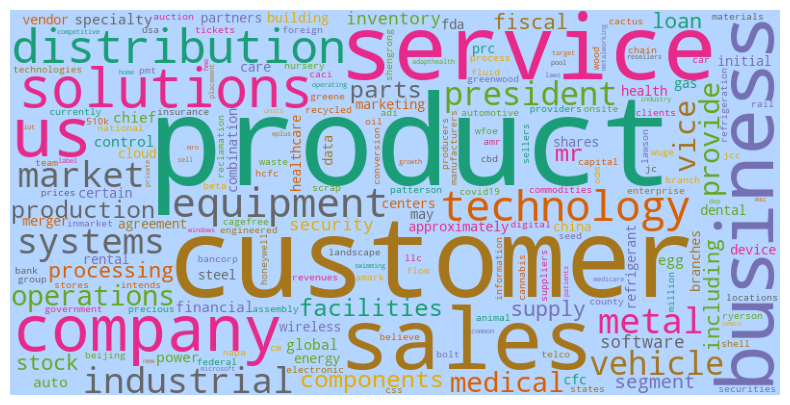

In [24]:
wordcloud_wc = WordCloud(width=800, height=400,background_color='#b4d5FF',colormap='Dark2', max_font_size=130).generate(' '.join(merged_pf_i1_2020.keyword_wc_top10.tolist()))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_wc)
plt.savefig(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\repo_data\imgs\keyword_wc.png')
plt.axis('off')
plt.show()

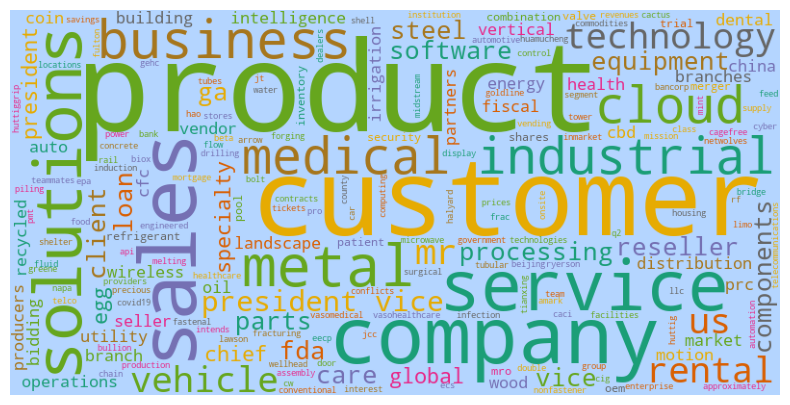

In [25]:
wordcloud_tfidf = WordCloud(width=800, height=400, background_color='#b4d5FF',colormap='Dark2', max_font_size=130).generate(' '.join(merged_pf_i1_2020.keyword_tfidf_top10.tolist()))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_tfidf)
plt.savefig(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\repo_data\imgs\keyword_tfidf.png') # save as PNG file
plt.axis('off')
plt.show()

E.	[Word embedding; 20 points] Train a word2vec model and analyze word similarities.
1.	Train a word2vec model with the full 10-K sample (e.g., "data/2020_10K_item1_full.csv"). Please use the cleaned text (e.g., results from Step C) for training.


In [26]:
try:
    model = Word2Vec.load(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\repo_data\models\word2vec.model')
except:
    sent = [row.split() for row in twenty20_10K_item1_clean['item_1_clean']]
    model = Word2Vec(sent, min_count=1, vector_size=50, workers=3, window=3, sg = 1)
    model.save(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\repo_data\models\word2vec.model')
    model = Word2Vec.load(r'C:\Users\sarda\Desktop\UBC\BAIT 508\Group_Project_BAIT508\repo_data\models\word2vec.model')

2.	Manually inspect the wordclouds you generated in D.3 and choose three representative keywords that are relevant to the industry sector of your interest. Utilize the trained word2vec model to find the most relevant five words for each of these three keywords.

In [27]:
#words_top10_wc = ['distribution','sales','service'] #Related to Wholesale
words_top10_tfidf = ['reseller','sales','service'] #Related to Wholesale

In [28]:
for _ in words_top10_tfidf:
    print(f'Similar words for {_}: {model.wv.most_similar(positive=_)[:5]}')
    

Similar words for reseller: [('resellers', 0.8645230531692505), ('dmrs', 0.8490561842918396), ('coselling', 0.8384497165679932), ('dtr', 0.8321585059165955), ('brokerdistributorretailer', 0.8319066762924194)]
Similar words for sales: [('telesales', 0.8358727097511292), ('marketing', 0.8223621845245361), ('canpotex', 0.8094435930252075), ('refranchising', 0.809317946434021), ('systemwide', 0.807682454586029)]
Similar words for service: [('aftersales', 0.8558439612388611), ('aftersale', 0.8345852494239807), ('noncable', 0.8345844149589539), ('postsale', 0.827005922794342), ('services', 0.8144283294677734)]


Part 3. Comprehensive Analysis of One Sample Firm
F.	[Firm Analysis and Strategy Suggestion; 10 points] This is an open question. Pick one firm that you are interested in and try to analyze its market status. The ultimate goal is to provide one valuable suggestion to the firm based on your analysis. Some directions you might consider are, but not limited to:
1.	Convert the keywords extracted in D.2 into word embeddings with the word2vec model trained in E.1. Add up the embeddings for each firm to create the firm-level embeddings. Use the firm-level embeddings to find the focal firm’s competing firms (or, most similar firms). 


In [29]:
dsimilar = DocumentSimilarity(model = model, gvkeys=merged_pf_i1_2020['gvkey'], conm = merged_pf_i1_2020['conm'], 
                       keywordslist = merged_pf_i1_2020['keyword_tfidf_top10'])
firm = 1773
dsimilar.get_firm_embedding(firm)
most_similar_firms_ = dsimilar.most_similar(firm, topn = 5)
most_similar_firms_

[(6617, 'LAWSON PRODUCTS', 0.91827446),
 (30714, 'TESSCO TECHNOLOGIES INC', 0.9110746),
 (4860, 'FOSTER (LB) CO', 0.8797521),
 (64223, 'DXP ENTERPRISES INC', 0.87024504),
 (1919, 'AVNET INC', 0.8610922)]

2.	Compare the revenue, market share, and ROA of the focal firm to its competitors and provide suggestions accordingly.

In [30]:
firms = []
for _ in most_similar_firms_:
    firms.append(firm)
    firms.append(_[0])
most_similar_firms = merged_pf_i1_2020[merged_pf_i1_2020['gvkey'].isin(firms)].copy()
most_similar_firms['revenue_per_sale'] = (most_similar_firms['sale'] - most_similar_firms['asset'])/most_similar_firms['sale']
most_similar_firms['market_share'] = most_similar_firms['sale'] / most_similar_firms['sale'].sum()
most_similar_firms

,gvkey,fyear,location,conm,ipodate,sic,prcc_c,ch,ni,asset,sale,roa,cik,year,item_1_text,item_1_clean,keyword_wc_top10,keyword_tfidf_top10,revenue_per_sale,market_share
1,1773,2020,USA,ARROW ELECTRONICS INC,NaN,5065,97.30,373.615,584.438,17053.911,28673.363,0.034270,7536,2020,"arrow electronics, inc. (the company or arr...",arrow electronics inc company arrow global pro...,company global business president chief vice c...,company ecs president vice global chief arrow ...,0.405235,0.590773
2,1919,2020,USA,AVNET INC,NaN,5065,35.11,477.038,-31.081,8105.197,17634.333,-0.003835,8858,2020,"background caci international inc (caci), a de...",background caci international inc caci delawar...,business caci government operations technology...,caci mission business government intelligence ...,0.540374,0.363330
4,4860,2020,USA,FOSTER (LB) CO,NaN,5051,15.05,7.564,7.582,370.395,497.411,0.020470,352825,2020,summary description of businesses formed in 19...,summary description businesses formed 1902 lb ...,company products rail president vice services ...,rail company piling president vice products tu...,0.255354,0.010248
9,6617,2020,USA,LAWSON PRODUCTS,NaN,5072,50.91,28.393,15.113,256.304,351.591,0.058965,703604,2020,"lawson products, inc. ( lawson , the company ...",lawson products inc lawson company us incorpor...,sales customers product products lawson bolt p...,lawson bolt sales customers president vice pro...,0.271017,0.007244
31,30714,2020,USA,TESSCO TECHNOLOGIES INC,1994/09/28,5065,6.24,1.110,-8.743,189.078,373.341,-0.046240,927355,2020,general tessco technologies incorporated (whic...,general tessco technologies incorporated somet...,customer products product customers informatio...,wireless tessco customer product fiscal produc...,0.493551,0.007692
48,64223,2020,USA,DXP ENTERPRISES INC,1996/12/27,5080,22.23,119.328,-29.269,868.131,1005.266,-0.033715,1020710,2020,company overview dxp was incorporated in texas...,company overview dxp incorporated texas 1996 s...,products dxp customers supply services service...,dxp pump mr packages mro vice industrial produ...,0.136417,0.020712


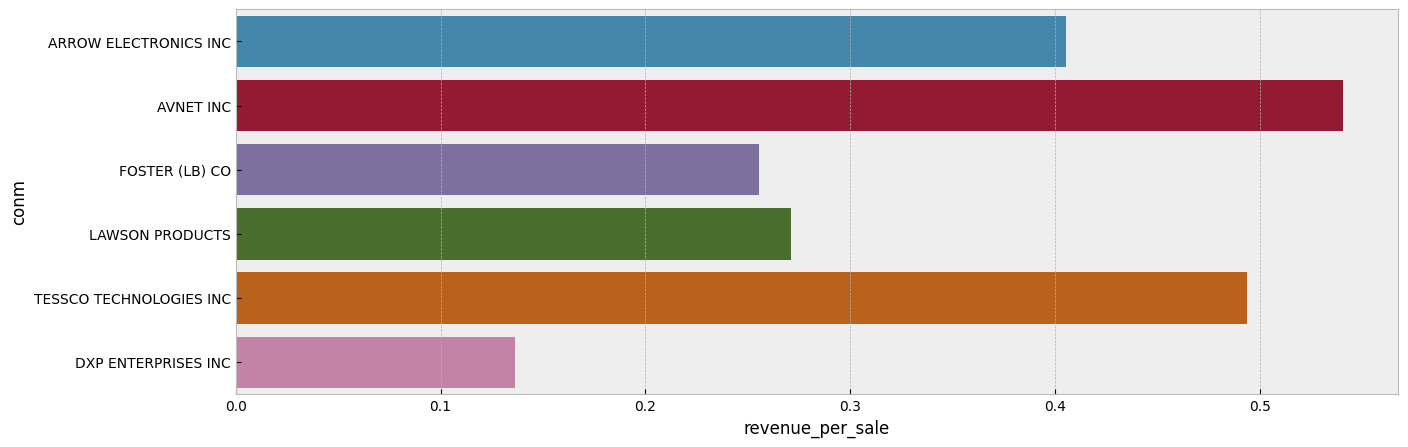

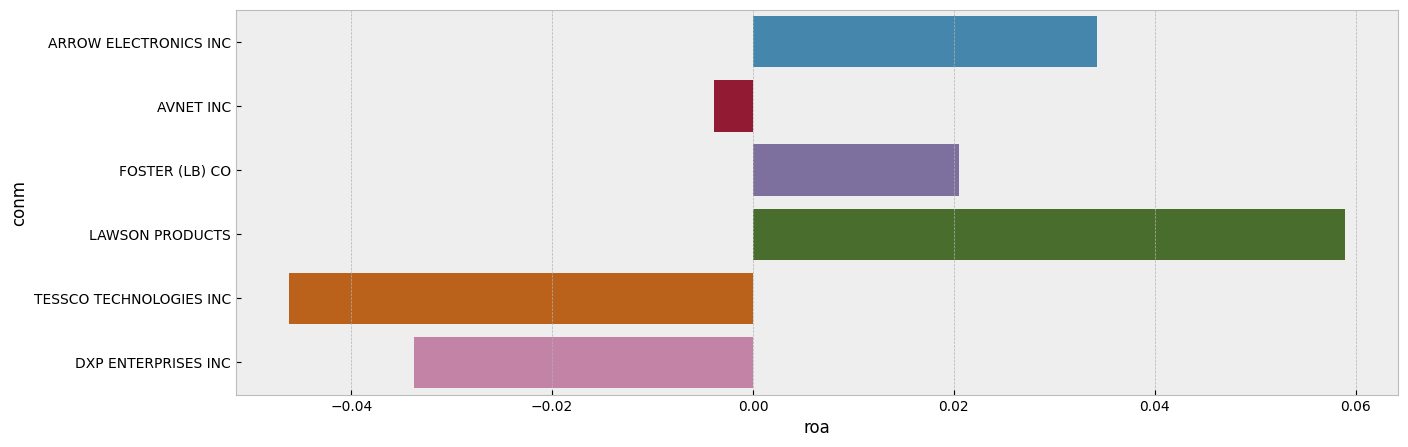

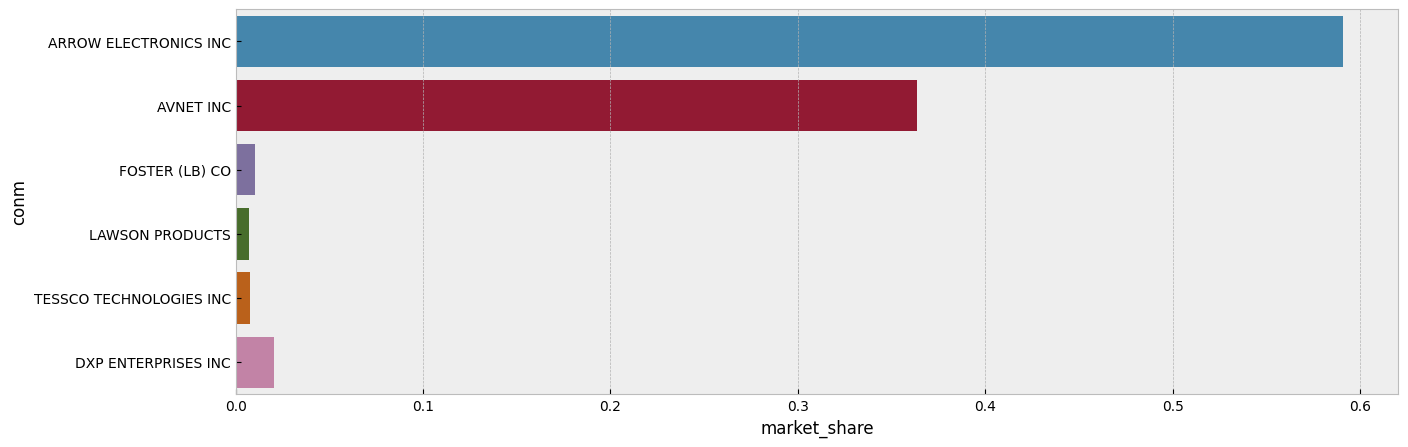

In [31]:
columns_to_plot = ['revenue_per_sale','roa', 'market_share']
for col in columns_to_plot:
    plt.figure(figsize=(15, 5))
    sns.barplot(x=col, y='conm', data=most_similar_firms)
    plt.savefig(f'imgs\\{col}.png')
    plt.show()
    

3.	Perform an analysis of the historical stock prices, ROA, revenue, and assets of the chosen company. Investigate potential correlations and address noteworthy decreases and increases.

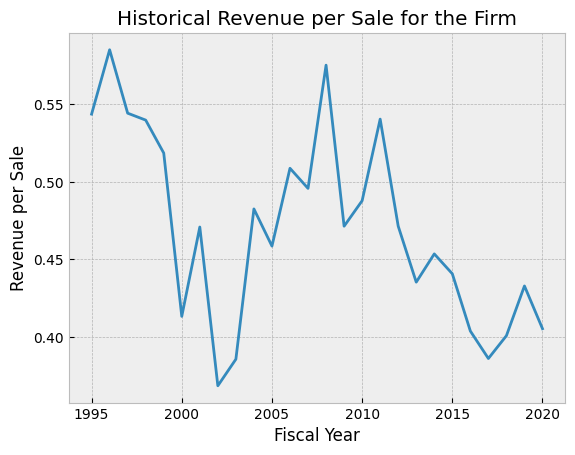

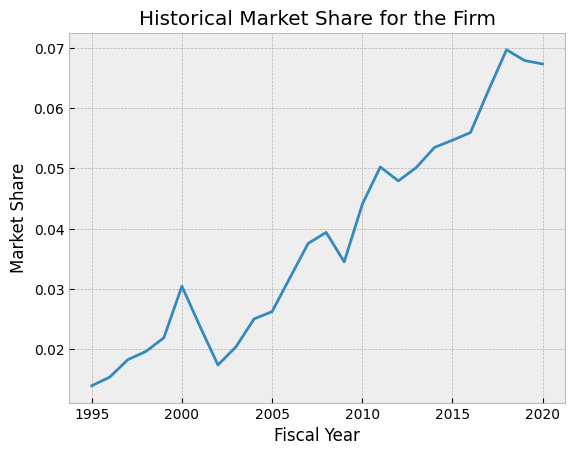

In [32]:
historical_data_for_firm = public_firms[public_firms['gvkey'] == firm].copy()
historical_data_for_firm
historical_data_for_firm['revenue_per_sale'] = (historical_data_for_firm['sale'] - historical_data_for_firm['asset'])/historical_data_for_firm['sale']
historical_data_for_firm['market_share'] = historical_data_for_firm['sale'] / historical_data_for_firm['sale'].sum()

import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x='fyear', y='revenue_per_sale', data=historical_data_for_firm)
plt.xlabel('Fiscal Year')
plt.ylabel('Revenue per Sale')
plt.title('Historical Revenue per Sale for the Firm')
plt.show()

sns.lineplot(x='fyear', y='market_share', data=historical_data_for_firm)
plt.xlabel('Fiscal Year')
plt.ylabel('Market Share')
plt.title('Historical Market Share for the Firm')
plt.show()

